# All Users Analysis 

We try to analyse here a subset of ```Weaponising``` or ```Not Weaponising``` edits linked with their corresponding user. We start from the raw dataframe and we apply pre processign techniques to clean it and adding some more relevant informations.

To run the notebook, simply run every cell one by one in descending order or Run all.

## Requierements

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import calendar
from tqdm import tqdm

## Load the main dataset

In [52]:
df = pd.read_csv("../datas/interim/All Users Analysis/matched_edits_all.csv")
df.shape

(6922, 25)

## matched_edits_all.csv metadata analysis

Some basic informations about the dataframe we are dealing with

### Users we are dealing with

In [54]:
print(df["user"].nunique(), "unique users found")
print()
print(df["user"].value_counts().head(10))  # Top users by edit count 
users_list = df['user'].unique().tolist() # List of all the users that has made at least one edit in the df.
top_users = (
    df
    .groupby("user")
    .size()
    .sort_values(ascending=False)
    .head(10)
    .index
)
top_users_list = list(top_users) # List of the top 10 users that have made the most edits in the df.

2336 unique users found

user
LSGH                   372
TheDraperyFalls        254
Aleksandr Grigoryev    162
Toddy1                 147
UP9                    138
Yulia Romero           127
Irpen                  116
Seryo93                113
Dbachmann              111
Mzajac                  94
Name: count, dtype: int64


### Articles we are dealing with

It seems that in the 41 unique article found, none are from the full scale Russia invasion in Ukraine.

In [6]:
print(df['article'].nunique(), "unique article found") # how many unique value articles
print(df["article"].value_counts()) #how many rows I have for each unique article

40 unique article found
article
COVID-19_pandemic_in_Ukraine_analysis                              1322
History_of_Ukraine_analysis                                        1175
Crimea_analysis                                                    1139
Annexation_of_Crimea_by_the_Russian_Federation_analysis             502
2004_Ukrainian_presidential_election_analysis                       425
Football_in_Ukraine_analysis                                        268
Bessarabia_analysis                                                 255
2014_pro-Russian_unrest_in_Ukraine_analysis                         249
Communist_Party_of_the_Soviet_Union_analysis                        217
Christianity_in_Russia_analysis                                     172
History_of_Christianity_in_Ukraine_analysis                         168
Flag_of_Ukraine_analysis                                            113
Alexander_II_of_Russia_analysis                                     101
Eastern_Front_(World_War_II)_ana

## Apply preprocess things on the dataframe to add more informations

In [57]:
df["year"] = pd.to_datetime(df["date"], errors="coerce").dt.year

# Drop the rows without valid year or weaponised label..
df = df.dropna(subset=["year", "weaponised"])

# Ensure correct types
df["year"] = df["year"].astype(int)

# Normalizing the weaponised field because there are some capitalised and soem not --> lowercase and strip
df["weaponised"] = df["weaponised"].astype(str).str.strip().str.lower()
df["weaponised"] = df["weaponised"].replace({
    "true": "Weaponised",
    "false": "Not Weaponised",
    "unknown": "Unknown",
    "weaponised": "Weaponised",
    "not weaponised": "Not Weaponised"
})

df["weaponised"].unique() # output : array(['Not Weaponised', 'Weaponised'], dtype=object) it works

ipv4_ipv6_pattern = (
    r"^(?:\d{1,3}\.){3}\d{1,3}$|"  # IPv4
    r"^(?:[A-Fa-f0-9]{0,4}:){2,7}[A-Fa-f0-9]{0,4}$"  # IPv6
)
df["is_anon"] = df["user"].str.contains(ipv4_ipv6_pattern, na=False)
df['is_bot'] = df['user'].str.contains('bot', case=False, na=False)

def get_user_type(row):
    if row["is_anon"]:
        return "Anonymous (IP)"
    elif row["is_bot"]:
        return "Bot"
    else:
        return "Registered"

df['user_type'] = df.apply(get_user_type, axis=1)

all_users_data = {
    # Overall dataset size
    "total_edits": len(df),
    "total_unique_users": df["user"].nunique(),
    "number_unique_articles": df["article"].nunique(),

    # User type counts (unique users)
    "num_bot_users": df.loc[df["is_bot"], "user"].nunique(),
    "num_anonymous_users": df.loc[df["is_anon"], "user"].nunique(),
    "num_registered_users": df.loc[~df["is_bot"] & ~df["is_anon"], "user"].nunique(),

    # Edit counts by user type
    "num_bot_edits": int(df["is_bot"].sum()),
    "num_anonymous_edits": int(df["is_anon"].sum()),
    "num_registered_edits": int(len(df) - (df["is_bot"].sum() + df["is_anon"].sum())),

    # Weaponisation counts
    "weaponised_edits": int((df["weaponised"] == "Weaponised").sum()),
    "non_weaponised_edits": int((df["weaponised"] == "Not Weaponised").sum())
}

## Plots to show some distribution

The following plots help to understand better how the edits are distributed over time and across the different user types. The different user types we are dealing with in the first place are Registered, Bot and IP users. Registered users are user that has an account on Wikipedia and can be identified by an ```user_id``` and a ```username``` while the IP user doesn't have an account. One can identify him only by his ```IP adress```. 

The plots are displayed as the following :
* Weaponised vs Non-Weaponised Edits per Year
* Weaponised vs Non-Weaponised Edits by User Type
* Weaponised vs Non-Weaponised Edits per Year for Top 10 Users
* Proportion of Missing Comments by User Type
* Heatmap of Weaponised Edits per Day per Group over every year
* Heatmap of Weaponised Edits per Weekday per Group over every year

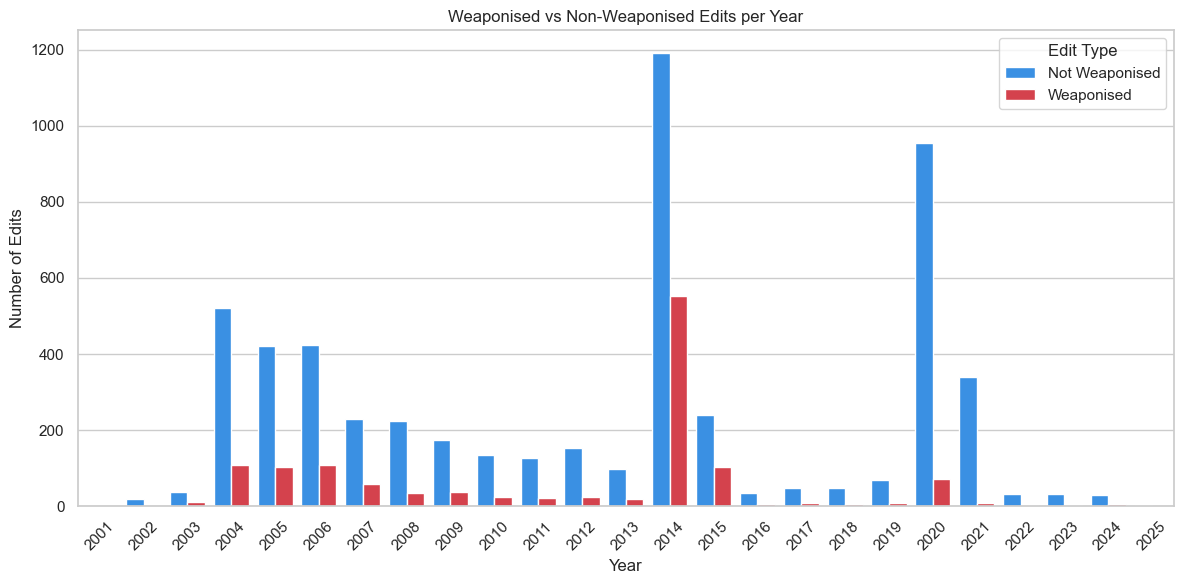

In [58]:
custom_palette = {
    "Weaponised": "#ed2939",      # red
    "Not Weaponised": "#1e90ff",   # royal blue
}

df_counts = df.groupby(["year", "weaponised"]).size().reset_index(name="count")

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_counts,
    x="year",
    y="count",
    hue="weaponised",
    palette=custom_palette
)

plt.title("Weaponised vs Non-Weaponised Edits per Year")
plt.xlabel("Year")
plt.ylabel("Number of Edits")
plt.legend(title="Edit Type")
plt.xticks(rotation=45)
plt.tight_layout()
fig_title = 'Weaponised vs Non-Weaponised Edits per Year'
#plt.savefig(f"../plots/All Users Analysis/{fig_title}.png", dpi=300, bbox_inches='tight')
plt.show()

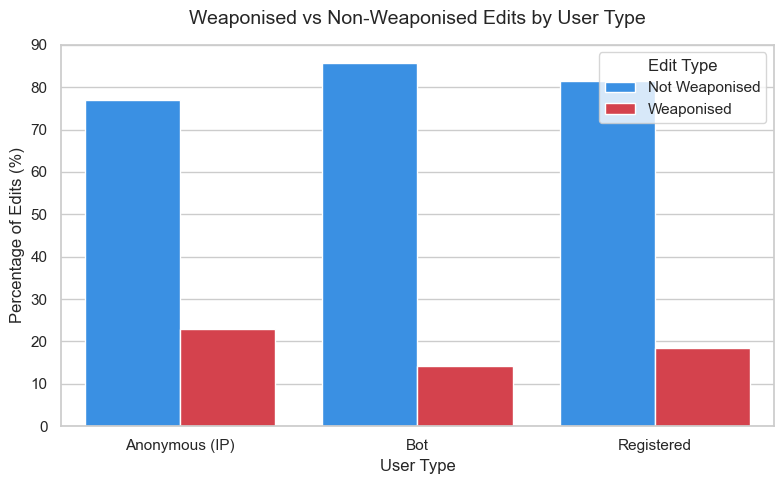

In [59]:
# Count how many edits of each type are weaponised / non-weaponised
comparison = (
    df.groupby(["user_type", "weaponised"])
    .size()
    .reset_index(name="count")
)

# Compute total edits per user type and percentage of weaponised edits
totals = comparison.groupby("user_type")["count"].sum().reset_index(name="total")
comparison = comparison.merge(totals, on="user_type")
comparison["percentage"] = (comparison["count"] / comparison["total"]) * 100

custom_palette = {
    "Weaponised": "#ed2939",      # red
    "Not Weaponised": "#1e90ff",   # royal blue
}

sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.barplot(
    data=comparison,
    x="user_type",
    y="percentage",
    hue="weaponised",
    palette=custom_palette
)

plt.title("Weaponised vs Non-Weaponised Edits by User Type", fontsize=14, pad=15)
plt.xlabel("User Type", fontsize=12)
plt.ylabel("Percentage of Edits (%)", fontsize=12)
plt.legend(title="Edit Type")
plt.tight_layout()
fig_title = 'Weaponised vs Non-Weaponised Edits by User Type'
#plt.savefig(f"../plots/All Users Analysis/{fig_title}.png", dpi=300, bbox_inches='tight')
plt.show()

/Users/garambois/miniforge3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_5825/2721682655.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

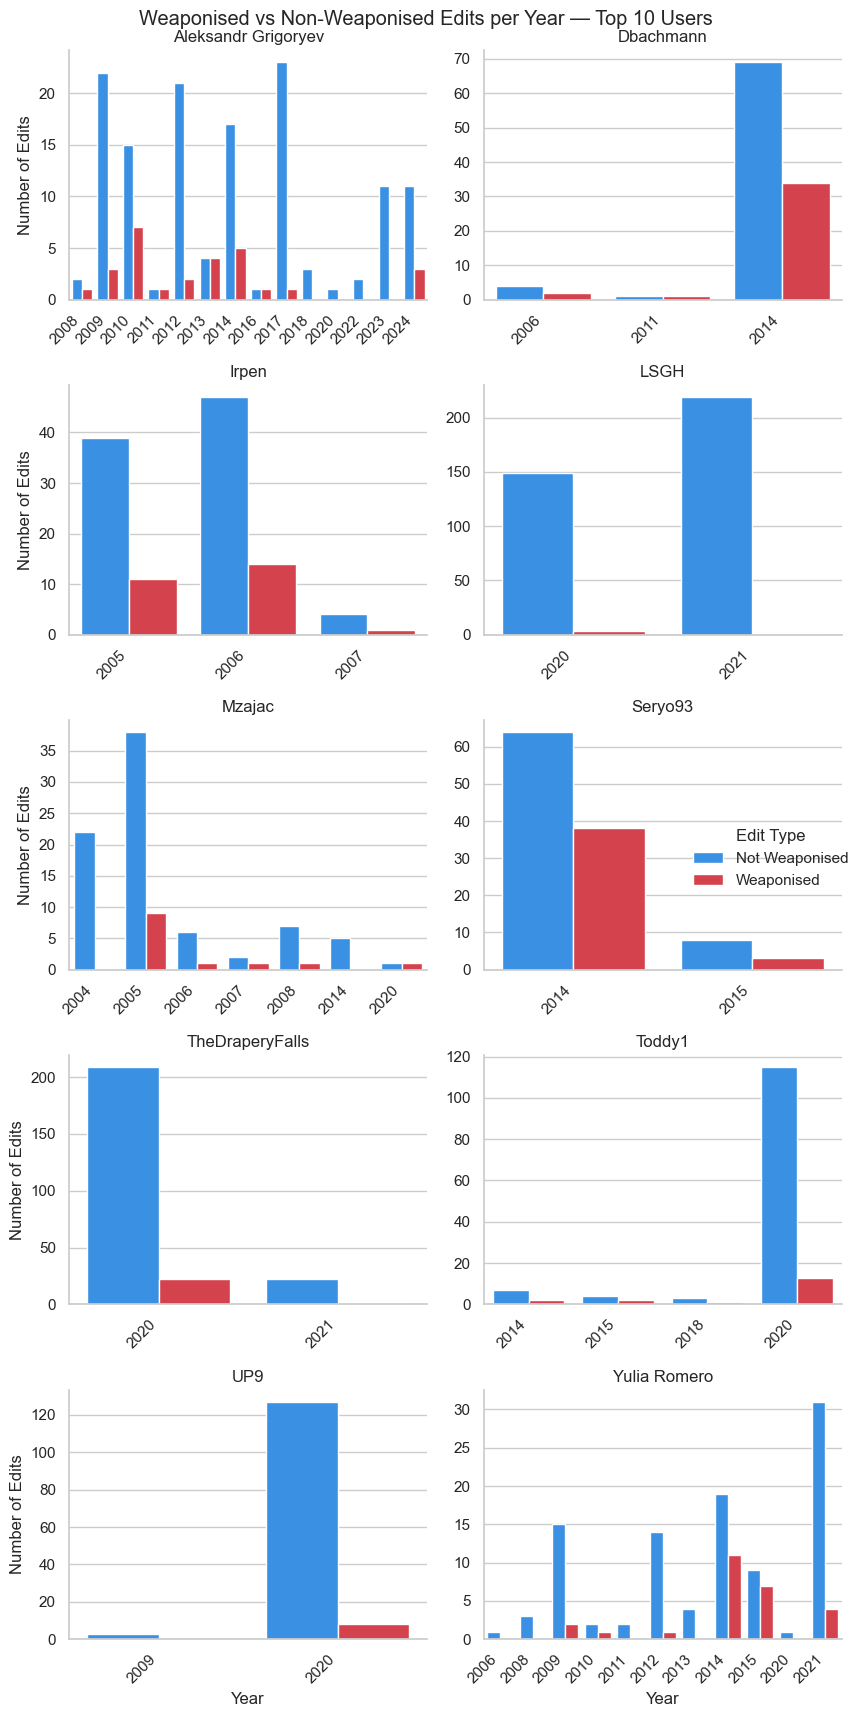

In [60]:
# jsut a subset of data for now. subset of df but with only the edits made by the top_users.
df_top = df[df["user"].isin(top_users_list)]

# count edits per (user, year, weaponised)
grouped = (
    df_top.groupby(["user", "year", "weaponised"])
    .size()
    .reset_index(name="count")
)

# Ensure seaborn style
custom_palette = {
    "Weaponised": "#ed2939",      # red
    "Not Weaponised": "#1e90ff"   # blue
}
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Create the barplot
g = sns.FacetGrid(grouped, col="user", col_wrap=2, height=3.5, sharey=False, sharex=False)
g.map_dataframe(sns.barplot, x="year", y="count", hue="weaponised", palette=custom_palette, errorbar=None)
g.add_legend(title="Edit Type")

g.set_titles("{col_name}")
g.set_axis_labels("Year", "Number of Edits")

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Weaponised vs Non-Weaponised Edits per Year — Top 10 Users")

for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

plt.tight_layout()
fig_title = 'Weaponised vs Non-Weaponised Edits per Year — Top 10 Users'
plt.xticks(rotation=45, ha='right')
#plt.savefig(f"../plots/All Users Analysis/{fig_title}.png", dpi=300, bbox_inches='tight')
plt.show()

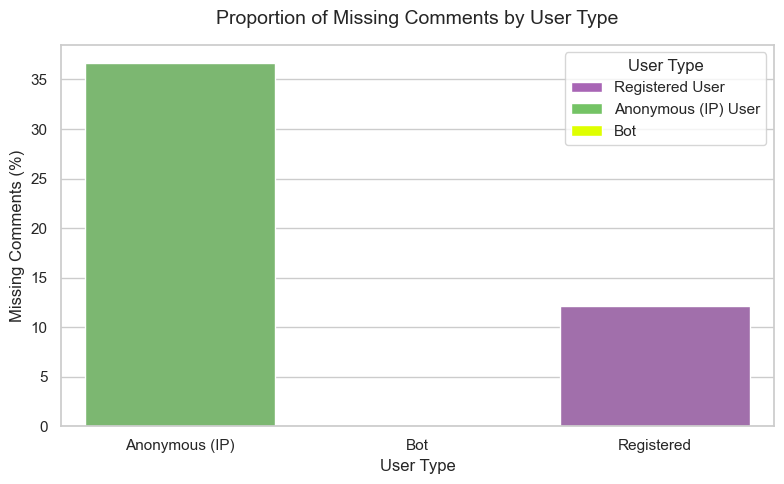

In [61]:
missing = (
    df[df["comment"].isna()]
    .groupby("user_type")
    .size()
    .reset_index(name="missing_count")
)

total = (
    df.groupby("user_type")
    .size()
    .reset_index(name="total_count")
)
comparison = missing.merge(total, on="user_type", how="right").fillna(0)
comparison["missing_percentage"] = (comparison["missing_count"] / comparison["total_count"]) * 100

comparison = comparison[comparison["user_type"].isin(["Registered", "Anonymous (IP)", "Bot"])]

custom_palette = {
    "Registered": "#a865b5",      
    "Anonymous (IP)": "#74c365", 
    "Bot": "#dfff00"
}

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

sns.barplot(
    data=comparison,
    x="user_type",
    y="missing_percentage",
    hue='user_type',
    palette=custom_palette
)

plt.title("Proportion of Missing Comments by User Type", fontsize=14, pad=15)
plt.xlabel("User Type", fontsize=12)
plt.ylabel("Missing Comments (%)", fontsize=12)
plt.tight_layout()

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="#a865b5", label="Registered User"),
    Patch(facecolor="#74c365", label="Anonymous (IP) User"),
    Patch(facecolor="#dfff00", label="Bot")
]
plt.legend(
    handles=legend_elements,
    title="User Type",
    loc="upper right",
    frameon=True
)

fig_title = "Proportion of Missing Comments by User Type"
plt.savefig(f"../plots/All Users Analysis/{fig_title}.png", dpi=300, bbox_inches="tight")
plt.show()

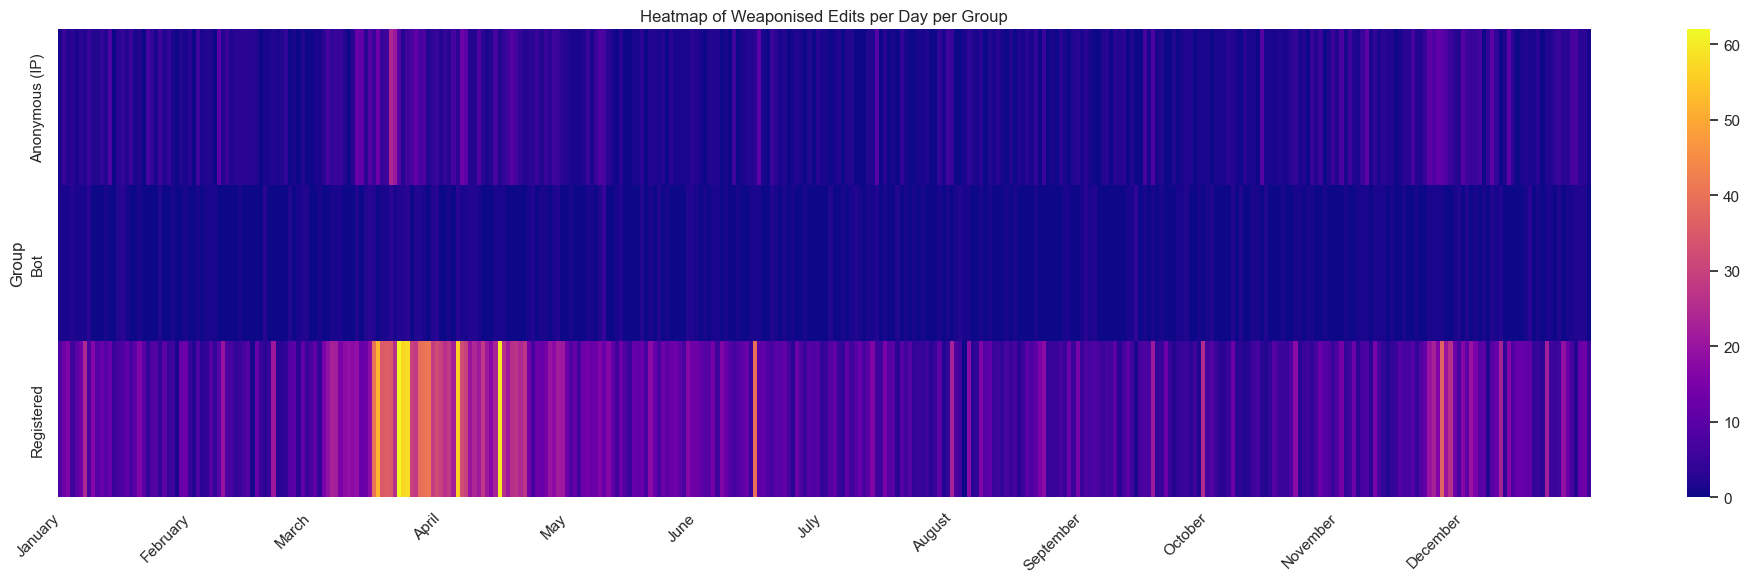

In [63]:
df_heatmap = df.copy()
df_heatmap = df_heatmap.drop(['is_bot', 'is_anon'], axis=1)
df_heatmap = df_heatmap[df_heatmap['weaponised'] == 'Not Weaponised']

dt = pd.to_datetime(df_heatmap["date"], errors="coerce")

df_heatmap["year"]  = dt.dt.year
df_heatmap["month"] = dt.dt.month
df_heatmap["day"]   = dt.dt.day
df_heatmap["doy"]   = dt.dt.dayofyear
df_heatmap["date"]  = dt.dt.date 

daily = df_heatmap.groupby(['user_type', 'date']).size().reset_index(name='count')

daily["doy"] = pd.to_datetime(daily["date"]).dt.dayofyear

final_heatmap = daily.pivot_table(
    index='user_type',
    columns='doy',
    values='count',
    aggfunc='sum'
)
final_heatmap = final_heatmap.fillna(0)
final_heatmap = final_heatmap.reindex(columns=range(1, 367), fill_value=0)

month_starts = [pd.Timestamp(f"2024-{m:02d}-01").dayofyear for m in range(1,13)]
month_names  = [calendar.month_name[m] for m in range(1,13)]

plt.figure(figsize=(20,6))
sns.heatmap(final_heatmap, cmap="plasma", cbar=True)

plt.xticks(month_starts, month_names, rotation=45, ha="right")
plt.xlabel("")
plt.ylabel("Group")
plt.title("Heatmap of Weaponised Edits per Day per Group")
plt.tight_layout()
title = "Heatmap of Weaponised Edits per Day per Group"
#plt.savefig(f"../plots/All Users Analysis/{title}.png", dpi=300, bbox_inches="tight")
plt.show()

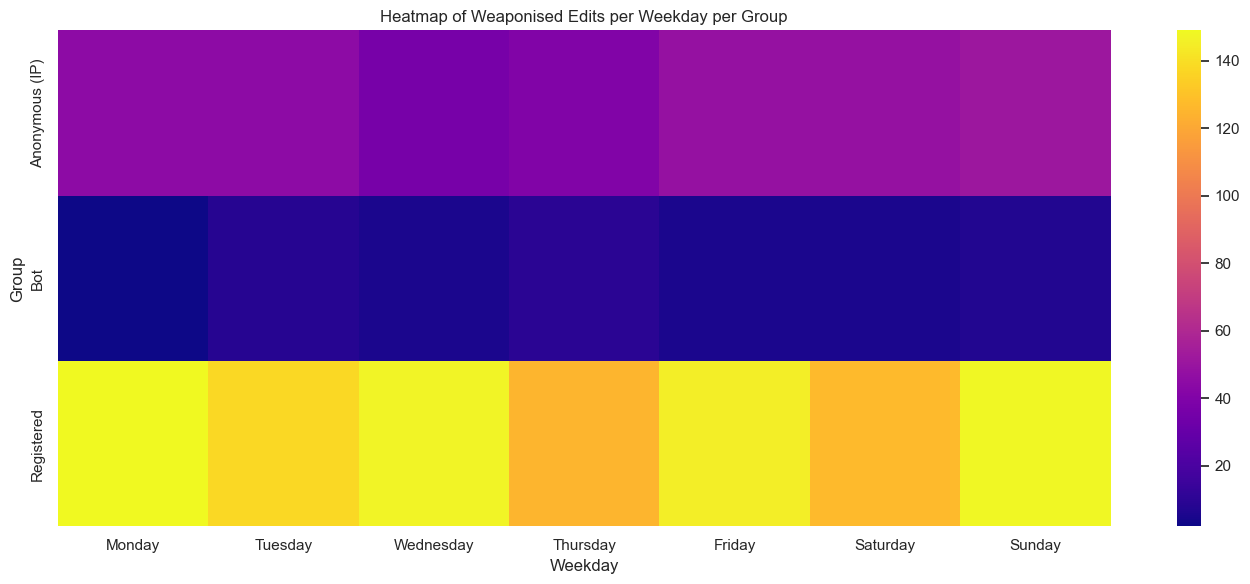

In [65]:
df_heatmap = df.copy()
df_heatmap = df_heatmap.drop(['is_bot', 'is_anon'], axis=1)
df_heatmap = df_heatmap[df_heatmap['weaponised'] == 'Weaponised']

# Convert date
dt = pd.to_datetime(df_heatmap["date"], errors="coerce")

df_heatmap["date"] = dt.dt.date
df_heatmap["weekday"] = dt.dt.weekday      # 0=Mon, 6=Sun
df_heatmap["weekday_name"] = dt.dt.day_name()

# Aggregate daily counts
daily = df_heatmap.groupby(['user_type', 'weaponised', 'date']).size().reset_index(name='count')

# Recompute weekday for daily table
daily["weekday"] = pd.to_datetime(daily["date"]).dt.weekday
daily["weekday_name"] = pd.to_datetime(daily["date"]).dt.day_name()

# Pivot: rows = user_type, columns = weekday (Mon→Sun)
final_heatmap = daily.pivot_table(
    index='user_type',
    columns='weekday_name',
    values='count',
    aggfunc='sum'
)

# Reorder columns to Mon→Sun
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
final_heatmap = final_heatmap[ordered_days]

# Fill missing entries
final_heatmap = final_heatmap.fillna(0)

plt.figure(figsize=(14, 6))
sns.heatmap(final_heatmap, cmap="plasma", cbar=True)

plt.xlabel("Weekday")
plt.ylabel("Group")
plt.title("Heatmap of Weaponised Edits per Weekday per Group")
plt.tight_layout()
title = "Heatmap of Weaponised Edits per Weekday per Group"
#plt.savefig(f"../plots/All Users Analysis/{title}.png",dpi=300, bbox_inches="tight")
plt.show()

## Informations about user's metadata

Here we want to have some informations about each user of the 2336 users list. The information we are able to get are unfortunately from the time I runned the API. It's very difficult to get information about the user by the time he made the edit.
> e.g The user Irpen in 2006 may have a completely different profil when he edited articles back then than today

In [62]:
top_users_metadata = pd.read_csv("../datas/interim/All Users Analysis/all_user_profiles.csv")
total_user_metadata = pd.read_csv('../datas/interim/All Users Analysis/total_user_profiles.csv')

## Info about user's contributions

The idea is to quantify for the top 10 users how much they focus their time in editing some Ukraine-Russia related articles among the large corpus of articles they edit daily or weekly. 

In [16]:
top_user_contribs_df = pd.read_csv('../datas/interim/All Users Analysis/top_user_contribs.csv')

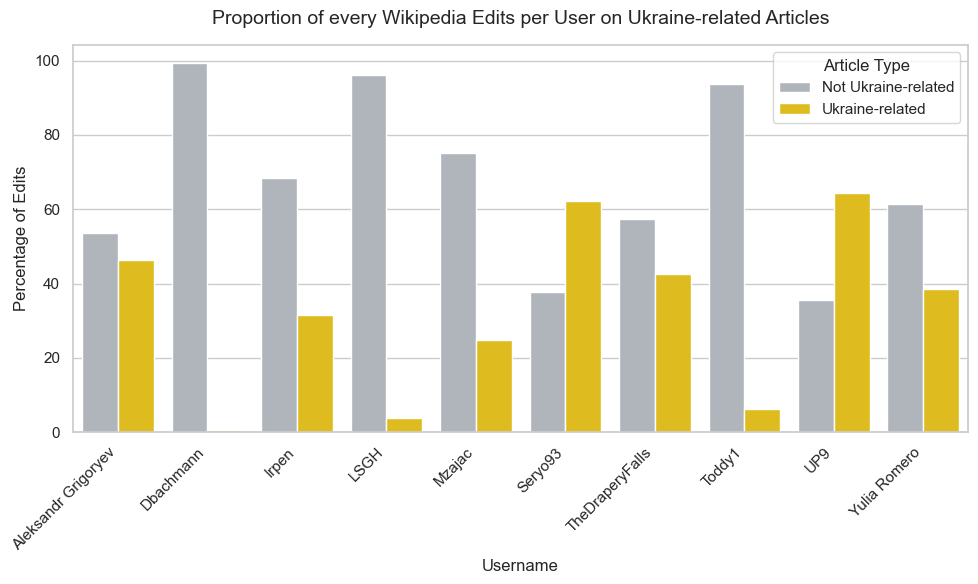

In [17]:
ukraine_keywords_small = [
    "ukraine", "ukrainian", "kyiv", "kiev", "crimea", "crimean", "kuban", "donbas", "donetsk", "luhansk",
    "maidan", "yanukovych", "yushchenko", "zelenskyy", "poroshenko", "catherine", "bukovina", "bessarabia", "eastern",
    "euromaidan", "dnipro", "odessa", "sevastopol", "putin", "rus'", "russia", "russian", "moscow", "kremlin", "soviet"
]

ukraine_keywords_large = [
    # core country and people
    "ukraine", "ukrainian", "kyiv", "kiev", "crimea", "crimean", "kuban", "donbas", "donetsk", "luhansk",
    "maidan", "yanukovych", "yushchenko", "zelenskyy", "poroshenko", "catherine", "bukovina", "bessarabia",
    "eastern", "euromaidan", "dnipro", "odessa", "sevastopol", "putin", "rus'", "russia", "russian", "moscow",
    "kremlin", "soviet",

    # politics & government
    "verkhovna rada", "president", "prime minister", "parliament", "government", "cabinet", "federation",
    "referendum", "annexation", "independence", "revolution", "reforms", "corruption", "sanctions",
    "occupation", "treaty", "agreement", "ceasefire", "negotiations", "elections", "coup", "unification",

    # geography & regions
    "zaporizhzhia", "mariupol", "kharkiv", "kherson", "mykolaiv", "chernihiv", "sumy", "poltava", "vinnytsia",
    "lviv", "ivano-frankivsk", "ternopil", "lutsk", "uzhhorod", "dnipropetrovsk", "donetsk oblast",
    "luhansk oblast", "transcarpathia", "prykarpattia", "galicia", "novorossiya", "black sea", "azov sea",

    # historical references
    "kyivan rus", "tsar", "imperial", "empire", "ussr", "communist", "lenin", "stalin", "bolshevik",
    "cold war", "perestroika", "glasnost", "collapse", "partition", "catherine the great", "brezhnev",
    "chernobyl", "orange revolution", "revolution of dignity", "holodomor", "soviet union",

    # war and military
    "invasion", "occupation", "annexed", "frontline", "offensive", "defense", "army", "forces", "military",
    "russian troops", "ukrainian forces", "separatist", "rebels", "paramilitary", "nato", "eu", "un", "war",
    "conflict", "shelling", "bombing", "airstrike", "occupation forces", "mobilization", "martial law",

    # culture, identity & language
    "language", "identity", "heritage", "culture", "orthodox", "church", "patriarch", "ukrainian language",
    "russian language", "minority", "bilingual", "autonomy", "nationalism", "independence day", "flag",
    "anthem", "symbol", "national identity", "sovereignty",

    # current / modern references
    "donbas war", "russian invasion", "ukrainian front", "crimea bridge", "moskva cruiser", "ukrainian army",
    "russian army", "zelensky", "kremlin propaganda", "occupation administration", "territorial defense",
    "european union", "eu membership", "nato membership", "nato expansion", "eu sanctions", "ukraine war",
    "full-scale invasion", "special military operation", "mobilisation", "referendum in crimea",

    # other
    "gas pipeline", "north stream", "energy crisis", "grain corridor", "black sea fleet", "peace talks",
    "donetsk people's republic", "luhansk people's republic", "kyiv oblast", "liberation", "resistance",
    "occupation zone", "ukrainian refugees", "mariupol steel plant", "azovstal", "bucha", "irpin", "kharkiv offensive"
]

def is_ukraine_related(title):
    if not isinstance(title, str):
        return False
    title_lower = title.lower()
    return any(kw in title_lower for kw in ukraine_keywords_small)

top_user_contribs_df["ukraine_related"] = top_user_contribs_df["title"].apply(is_ukraine_related)

user_distribution = (
    top_user_contribs_df
    .groupby(["username", "ukraine_related"])
    .size()
    .reset_index(name="count")
)

# Convert to percentages
user_distribution["percentage"] = (
    user_distribution.groupby("username")["count"].transform(lambda x: 100 * x / x.sum())
)

sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})

# Define a clear color palette (blue = Ukraine-related, grey = not related)
palette = {True: "#fed000", False: "#adb5bd"}

ax = sns.barplot(
    data=user_distribution,
    x="username",
    y="percentage",
    hue="ukraine_related",
    palette=palette
)

plt.title("Proportion of every Wikipedia Edits per User on Ukraine-related Articles", fontsize=14, pad=15)
plt.xlabel("Username", fontsize=12)
plt.ylabel("Percentage of Edits", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Fix legend: ensure correct order and labels
handles, labels = ax.get_legend_handles_labels()
new_labels = ["Ukraine-related", "Not Ukraine-related"] if labels[0] == "True" else ["Not Ukraine-related", "Ukraine-related"]
plt.legend(handles=handles, labels=new_labels, title="Article Type", loc="upper right")
fig_title = "Proportion of every Wikipedia Edits per Top 10 Registered User on Ukraine-related Articles"
#plt.savefig(f"../plots/All Users Analysis/{fig_title}_small.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [18]:
user_distribution = (
    top_user_contribs_df
    .groupby(["username", "ukraine_related", "title"])
    .size()
    .reset_index(name="count")
)

user_distribution = user_distribution[user_distribution['ukraine_related'] == True]
user_distribution_article_list = user_distribution['title'].unique().tolist()
for user in top_users_list:
    user_distribution_specific = user_distribution[user_distribution['username'] == user]
    print(f"for user : {user}, we have {user_distribution_specific['count'].sum()} edits for {user_distribution_specific['title'].nunique()} of articles.")
    print()

for user : LSGH, we have 2264 edits for 19 of articles.

for user : TheDraperyFalls, we have 4750 edits for 395 of articles.

for user : Aleksandr Grigoryev, we have 73656 edits for 5988 of articles.

for user : Toddy1, we have 3253 edits for 387 of articles.

for user : UP9, we have 252 edits for 19 of articles.

for user : Yulia Romero, we have 26475 edits for 2886 of articles.

for user : Irpen, we have 9808 edits for 1023 of articles.

for user : Seryo93, we have 2937 edits for 380 of articles.

for user : Dbachmann, we have 1607 edits for 472 of articles.

for user : Mzajac, we have 16221 edits for 3490 of articles.



In [19]:
# jsut a subset of data for now. subset of df but with only the edits made by the top_users.
df_top = df[df["user"].isin(top_users_list)]

# count edits per (user, year, weaponised)
grouped = (
    df_top.groupby(["user", "article", "weaponised"])
    .size()
    .reset_index(name="count")
)

grouped = grouped[grouped['user'] == 'Seryo93']
user_distribution_specific = user_distribution[user_distribution['username'] == 'Dbachmann']
user_distribution_specific

,username,ukraine_related,title,count
73782,Dbachmann,True,1682 Moscow uprising,1
73783,Dbachmann,True,18th century Russia,1
73784,Dbachmann,True,1945 Moscow Victory Parade,1
73785,Dbachmann,True,2002 Russian census,1
73786,Dbachmann,True,2015 Russian Sukhoi Su-24 shootdown,2
...,...,...,...,...
74249,Dbachmann,True,Ukrainians in the United Kingdom,1
74250,Dbachmann,True,User talk:Crzrussian,1
74251,Dbachmann,True,User talk:Electionworld/Atlas:Russia,1
74252,Dbachmann,True,Wikipedia:Articles for deletion/Assumption by ...,1


In [41]:
df_heatmap['year'].unique()

[2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024,
 2025]